# 🧪 Iris Classification with PyTorch and Optuna Hyperparameter Tuning

In [1]:
!uv add --active --dev optuna torch scikit-learn matplotlib pandas

Resolved 156 packages in 56ms                                        
Prepared 1 package in 478ms                                              
Uninstalled 1 package in 0.40ms
Installed 1 package in 0.63mse:///home/stavros/lab/mlops)   
 ~ mlops==0.1.0 (from file:///home/stavros/lab/mlops)


In [2]:
import matplotlib.pyplot as plt
import optuna
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/home/stavros/lab/mlops/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class IrisOpt(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation, dropout):
        super().__init__()
        act_fn = nn.ReLU() if activation == "relu" else nn.GELU()
        layers = []

        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(act_fn)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h_dim

        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [4]:
def objective(trial):
    # Hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 2)
    hidden_dims = [trial.suggest_categorical(f"hidden_dim_{i}", [16, 32, 64]) for i in range(n_layers)]
    activation = trial.suggest_categorical("activation", ["relu"])
    dropout = trial.suggest_float("dropout", 0.0, 0.2)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    # Load and prepare data
    iris = load_iris()
    X, y = iris.data, iris.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Initialize model
    model = IrisOpt(input_dim=4, hidden_dims=hidden_dims, output_dim=3,
                    activation=activation, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Train
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        pred = model(X_test_tensor)
        predicted_labels = torch.argmax(pred, dim=1)
        acc = accuracy_score(y_test_tensor.numpy(), predicted_labels.numpy())
    return acc

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-07-19 17:33:27,694] A new study created in memory with name: no-name-66021332-679a-4a5b-bc01-5960d83c468c
[I 2025-07-19 17:33:28,444] Trial 0 finished with value: 0.36666666666666664 and parameters: {'n_layers': 2, 'hidden_dim_0': 16, 'hidden_dim_1': 16, 'activation': 'relu', 'dropout': 0.0953654732602344, 'lr': 0.00010939608946268461}. Best is trial 0 with value: 0.36666666666666664.
[I 2025-07-19 17:33:28,504] Trial 1 finished with value: 0.9333333333333333 and parameters: {'n_layers': 2, 'hidden_dim_0': 16, 'hidden_dim_1': 32, 'activation': 'relu', 'dropout': 0.17634858843622203, 'lr': 0.0018688815679417572}. Best is trial 1 with value: 0.9333333333333333.
[I 2025-07-19 17:33:28,555] Trial 2 finished with value: 0.9333333333333333 and parameters: {'n_layers': 1, 'hidden_dim_0': 64, 'activation': 'relu', 'dropout': 0.08057890878429051, 'lr': 0.0009738687536009305}. Best is trial 1 with value: 0.9333333333333333.
[I 2025-07-19 17:33:28,617] Trial 3 finished with value: 1.0 and

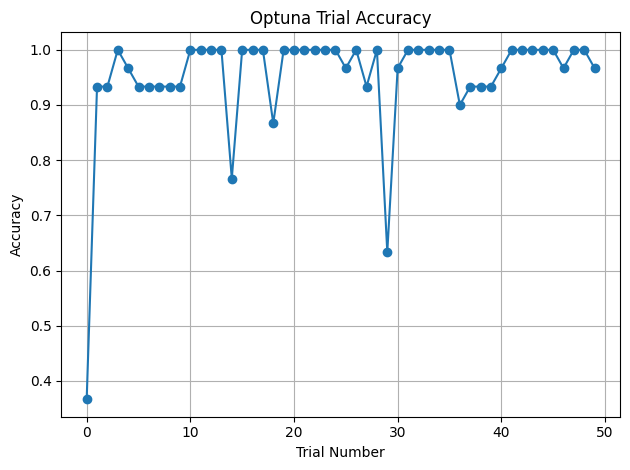

In [6]:
trials = study.trials_dataframe()
plt.plot(trials["number"], trials["value"], marker="o", linestyle="-")
plt.title("Optuna Trial Accuracy")
plt.xlabel("Trial Number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("opt_loss_plot.png")
plt.show()

In [7]:
best_trial = study.best_trial
best_trial_values = {
    "accuracy": best_trial.value,
    "params": best_trial.params
}
best_trial_values

{'accuracy': 1.0,
 'params': {'n_layers': 2,
  'hidden_dim_0': 32,
  'hidden_dim_1': 32,
  'activation': 'relu',
  'dropout': 0.009193951084461749,
  'lr': 0.003906566598872787}}